VESTAAAAAAAAAAAAAAAAAAAA's cells

In [3]:
import pyFAI
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import fabio
from pyFAI.gui import jupyter
import silx
import pygix
import math
import pandas as pd

print("Using pyFAI version",pyFAI.version)
%matplotlib inline
%pylab inline

ERROR:pygix.transform:Unable to import pyFAI.ocl_azim_csr: cannot import name 'ocl_azim_csr' from 'pyFAI' (C:\Users\19412\anaconda3\lib\site-packages\pyFAI\__init__.py)
ERROR:pygix.transform:Unable to import pyFAI.ocl_azim_lut for: cannot import name 'ocl_azim_lut' from 'pyFAI' (C:\Users\19412\anaconda3\lib\site-packages\pyFAI\__init__.py)
ERROR:pygix.transform:Unable to import pyFAI.ocl_sort for: cannot import name 'ocl_sort' from 'pyFAI' (C:\Users\19412\anaconda3\lib\site-packages\pyFAI\__init__.py)


Using pyFAI version 0.19.0
Populating the interactive namespace from numpy and matplotlib


Use anaconda prompt to run "pyFAI-calib2" and follow the documentation to create a .poni file for the detector and calibrant

Use anaconda prompt to run "pyFAI-drawmask filename.tif" and follow the documentation to create a .edf mask file for the image you are analyzing

<AxesSubplot:title={'center':'FASnI3'}>

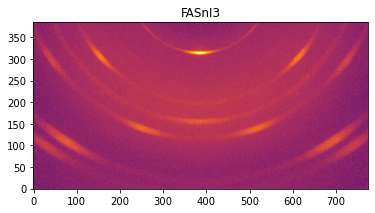

In [73]:
##### LOADING IMAGES #####
path='C:\\Users\\19412\\Documents\\Research\\Data\\FASnI3\\0605_NSLS_films\\220606-SnPVSK-CuKa-WAXS\\'
sample='PS'
### converting tif to edf ###
img = fabio.open(path+'220606_FASnI3-'+sample+'2-2DWAXS-2deg-25_2T_1_image.tiff')

img.convert("edf").save("x.edf")

# darkimg = fabio.open('siwafer.tif')
# darkimg.convert("edf").save("siwafer.edf")

### loading image ###
img = fabio.open('x.edf').data
# mask = fabio.open('c60_2-mask.edf').data
# dark = fabio.open('siwafer.edf').data
jupyter.display(img,label = "FASnI3")

# "C:\Users\19412\Documents\Research\Data\FASnI3\0605_NSLS_films\220606-SnPVSK-CuKa-WAXS\220606_FASnI3-C2-2DWAXS-2deg-25_2T_1_image.tiff"

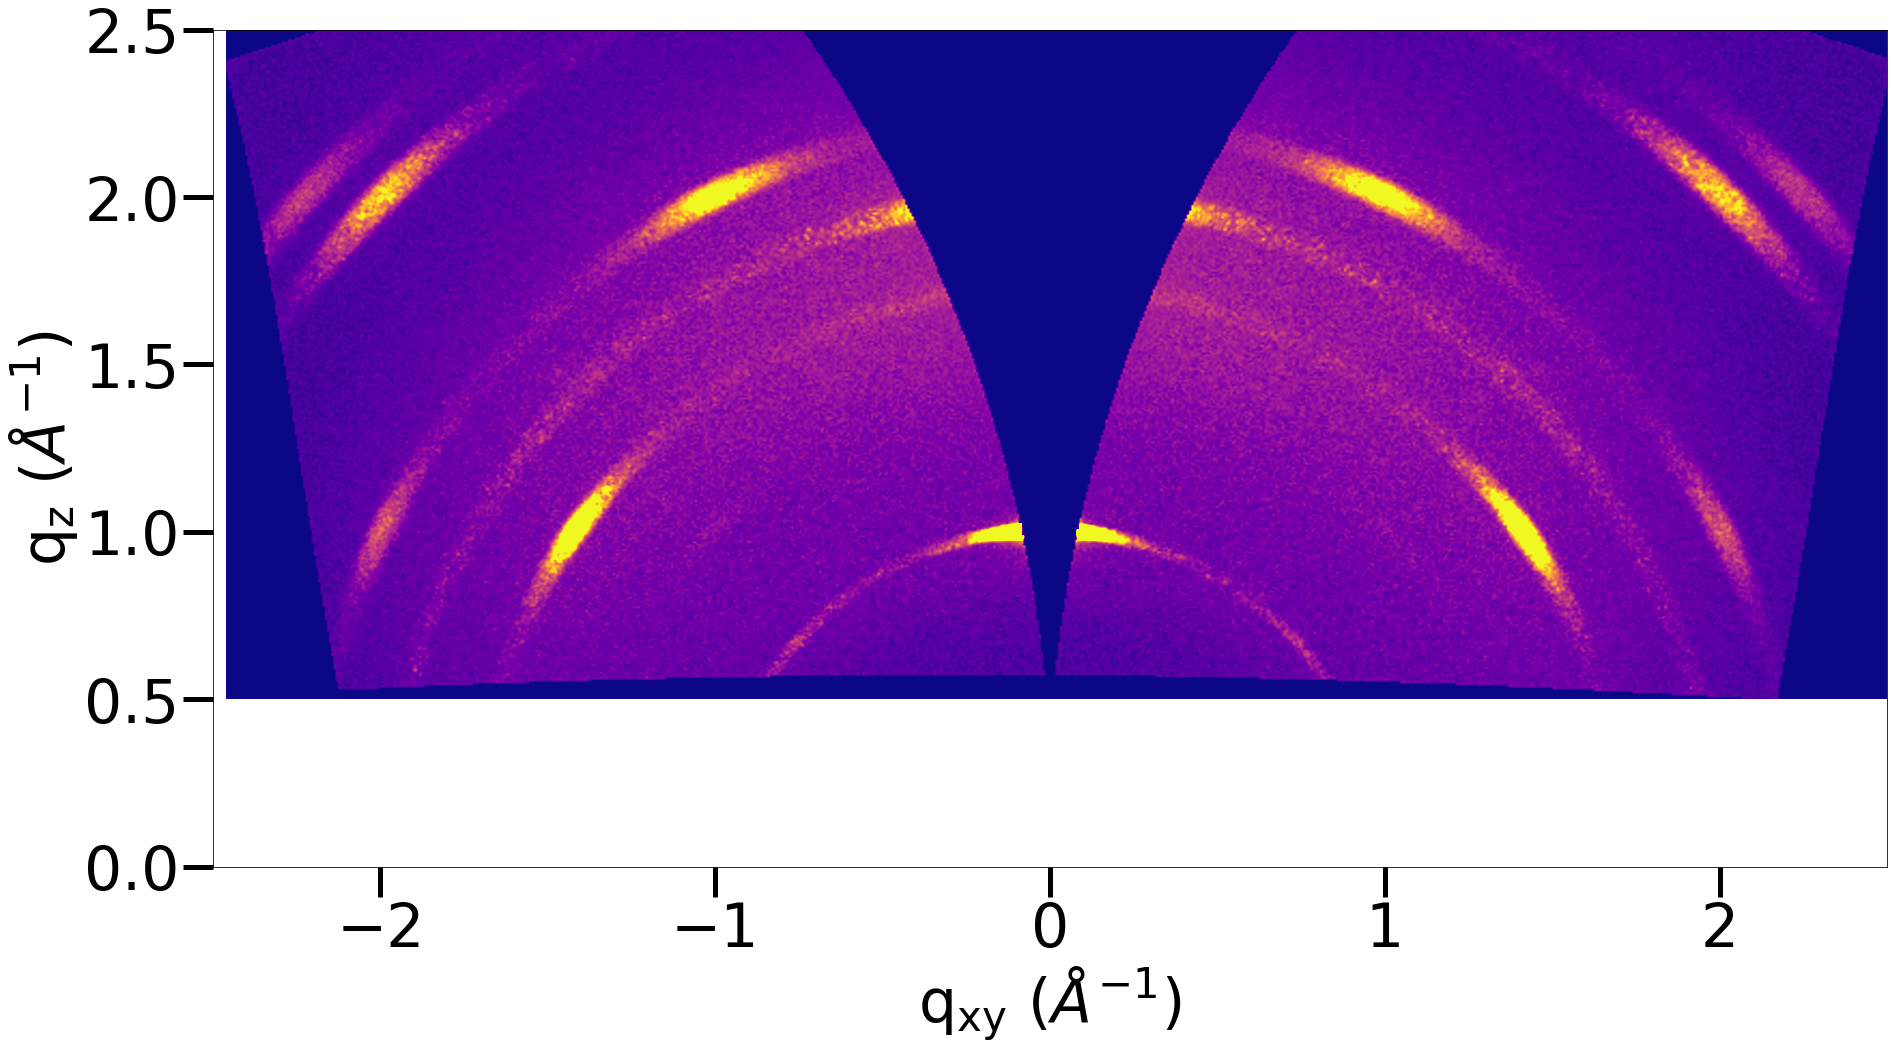

In [83]:
##### CONVERSION TO RECIPROCAL SPACE #####
# from pyFAI.calibrant import get_calibrant
# from pyFAI.azimuthalIntegrator import AzimuthalIntegrator

pg = pygix.Transform()

pg.load("C:\\Users\\19412\\Documents\\Research\\Data\\FASnI3\\RigakuAl2O3_ref3.poni")
# pg.maskfile = 'c60-mask.edf'
# pg.darkfile = 'siwafer.edf'     # baseline file here



pg.sample_orientation = 3
pg.incident_angle = 2
# pg.tilt_angle = 0

img_rec, qxy, qz = pg.transform_reciprocal(img,
                                           method = "bbox",
                                           unit = "A")

figure(figsize = (30,30))

plt.imshow(img_rec,
           extent=(np.min(qxy),np.max(qxy),np.min(qz),np.max(qz)),
           origin = "lower",
           interpolation='spline16')

plt.xlabel('$\mathregular{q_{xy}}$ ($\AA^{-1}$)', fontsize=60)
plt.xticks(fontsize=60)
plt.ylabel('$\mathregular{q_z}$ ($\AA^{-1}$)',fontsize=60)
plt.yticks(fontsize=60)
plt.ylim(0,2.5)
plt.xlim(-2.5,2.5)
plt.tick_params(axis="y", labelsize=60, length=30, width=5)
plt.tick_params(axis="x", labelsize=60, length=30, width=5)

plt.set_cmap('plasma')
lb = np.nanpercentile(img_rec,0)
ub = np.nanpercentile(img_rec,99.5)
plt.clim(lb,ub)

plt.savefig(path+'analysis\\FASnI3_P_extended.png',dpi=400)


Detector Detector	 Spline= None	 PixelSize= 1.000e-04, 1.000e-04 m
Wavelength= 1.540000e-10m
SampleDetDist= 6.295481e-02m	PONI= 1.904227e-02, 4.014680e-02m	rot1=0.022707  rot2= 0.439737  rot3= 0.000000 rad
DirectBeamDist= 69.592mm	Center: x=387.170, y=486.676 pix	Tilt=25.226 deg  tiltPlanRotation= 92.763 deg


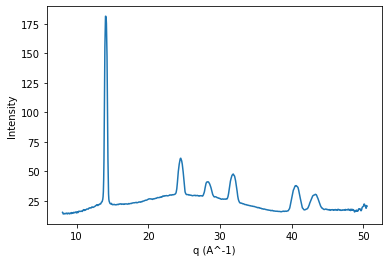

In [75]:
##### 1D INTEGRATION ##### 
import pandas as pd

ai = pyFAI.load("C:\\Users\\19412\\Documents\\Research\\Data\\FASnI3\\RigakuAl2O3_ref3.poni")
path='C:\\Users\\19412\\Documents\\Research\\Data\\FASnI3\\0605_NSLS_films\\220606-SnPVSK-CuKa-WAXS\\'
print(ai)

res = ai.integrate1d(img,
                    1000,   # number of points in the output
                    unit="2th_deg",
#                     unit="q_A^-1",
                    azimuth_range=(-175,-5))

##### displaying integration result
tth=res[0]
I=res[1]
plt.plot(tth,I)
plt.xlabel("q (A^-1)")
plt.ylabel("Intensity")

### exporting data to csv
b = np.array(tth)
c = np.array(I)
df=pd.DataFrame({"q" : b, "Intensity" : c})
df.to_csv(path+'analysis\\'+sample+'_1D_2th.csv',index=False)


[14.039007851583442, 24.53910497146569, 28.280030261140336, 31.850913492193406, 40.65059002585991, 43.32875244914971, 49.4927770741818, 50.13043479401271]


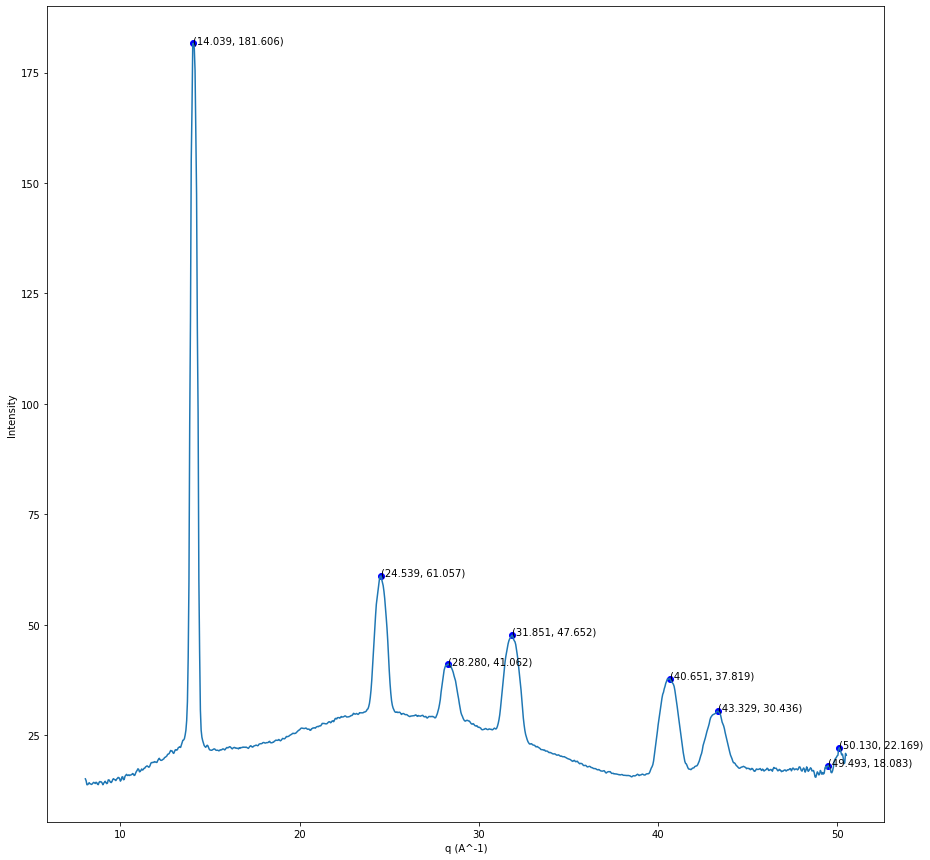

In [76]:
##### PEAK FINDER #####

import pandas as pd
import scipy as sp
from scipy import signal
import csv

# peaks=[]
# peaks=sp.signal.find_peaks(I,prominence=10,width=0.5,distance=50)[0]

# peaks_tth=[]
# for i in range(0,len(peaks)):
#     peaks_tth.append(tth[peaks[i]])
# print(peaks_tth)

# ##### displaying peaks
# fig = plt.figure()
# ax = fig.add_subplot(111)
    
# ax.plot(peaks_tth,I[peaks], "ob");
# ax.plot(tth,I)
# plt.xlabel("q (A^-1)")
# plt.ylabel("Intensity")
# plt.gcf().set_size_inches(15,15)

# for xy in zip(peaks_tth,I[peaks]):
#     ax.annotate('(%.3f, %.3f)' %xy, xy=xy, textcoords='data')

# ##### saving list of peaks in csv
# a = np.array(peaks_tth)
# aa = np.array(I[peaks])
# dfa=pd.DataFrame({"peak_2theta" : a, "peak_intensity" : aa})
# # dfa.to_csv("peaks_c60_avg.csv",index=False)

##### MODIFICATION FOR NSLS CSV

I=pd.read_csv(path+'analysis\\'+sample+'_1D_2th.csv')

peaks=[]
peaks=sp.signal.find_peaks(I['Intensity'],prominence=1,width=5,distance=10)[0]

tth=I['q']
peaks_tth=[]
for i in range(0,len(peaks)):
    peaks_tth.append(tth[peaks[i]])
print(peaks_tth)

##### displaying peaks
fig = plt.figure()
ax = fig.add_subplot(111)
    
ax.plot(peaks_tth,I['Intensity'][peaks], "ob");
ax.plot(I['q'],I['Intensity'])
plt.xlabel("q (A^-1)")
plt.ylabel("Intensity")
plt.gcf().set_size_inches(15,15)

for xy in zip(peaks_tth,I['Intensity'][peaks]):
    ax.annotate('(%.3f, %.3f)' %xy, xy=xy, textcoords='data')

##### saving list of peaks in csv
# a = np.array(peaks_tth)
# aa = np.array(I[peaks])
# dfa=pd.DataFrame({"peak_2theta" : a, "peak_intensity" : aa})
# dfa.to_csv("peaks_c60_avg.csv",index=False)

<AxesSubplot:title={'center':'2D regrouping'}, xlabel='Scattering angle $2\\theta$ ($^{o}$)', ylabel='Azimuthal angle $\\chi$ ($^{o}$)'>

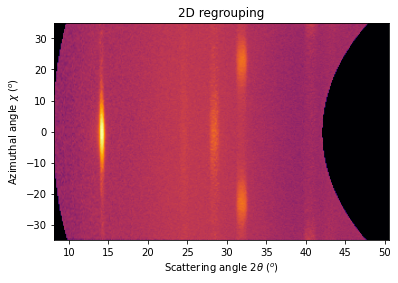

In [77]:
##### CAKING #####

res2d=ai.integrate2d(img,
                    300,    # number of points in radial direction
                    500,    # number of points in azimuthal direction
#                     unit="q_A^-1",
                     unit='2th_deg',
#                     method="con",     # default method
                    azimuth_range=(-125,-55))

# pulling intensity, 2-theta, and azimuthal arrays out
I2, tth2, chi = res2d
for i in range(0,len(chi)):     #changes reference of azimuthal angle to increase clockwise from qx axis
    chi[i]=chi[i]+90

    
# display integration result
jupyter.plot2d(res2d,label="sample 2D regrouping")
# plt.savefig(path+'\\analysis\\P_cake.tiff',dpi=600)

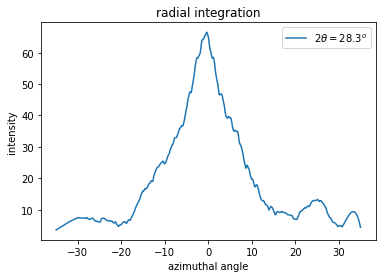

In [78]:
##### RADIAL INTEGRATION #####

#### SINGLE target
target = peaks_tth[2] # target scattering angle (degrees) SINGLE
column = np.argmin(abs(tth2-target))     # defines column number (scattering angle) SINGLE

## extracting background
b1_target=target+2
col_b1=np.argmin(abs(tth2-b1_target))
yb1=I2[:,col_b1]

b2_target=target-2
col_b2=np.argmin(abs(tth2-b2_target))
yb2=I2[:,col_b2]

bavg=[]
for i in range(len(yb1)):
    bavg.append((yb1[i]+yb2[i])/2)

## display integration
fig,ax = plt.subplots()
y=I2[:,column]-bavg
y=signal.savgol_filter(y,61,3)                            #smoothing
ax.plot(chi,y,label=r"$2\theta=%.1f^{o}$"%target)
ax.set_xlabel("azimuthal angle")
ax.set_ylabel("intensity")
ax.set_title("radial integration")
ax.legend()

##### ARRAY of targets
# target = peaks_tth      # target angles ARRAY
# column=[]
# for i in range(0,len(target)):
#     column.append(np.argmin(abs(tth2-target[i])))
# nrows=len(peaks_tth)

# fig, ax = plt.subplots()

# dfa=pd.DataFrame(pd.Series(chi))
# # dfa=pd.DataFrame({"chi" : a, "peak_intensity" : aa})

# for i in range(0,len(target)):
#     I2m=pd.Series(I2[:,column[i]])
#     y=I2m.iloc[:].rolling(window=20).mean().fillna(method='bfill')      #smoothing
#     plt.plot(chi,y,label=r"$2\theta=%.1f^{o}$"%target[i])
#     plt.xlabel("azimuthal angle")
#     plt.ylabel("intensity")
#     plt.legend()
#     plt.show()
#     dfa=pd.concat([dfa,y],axis=1,ignore_index=True)
    
##### saving chi-plots
# display(dfa)
#     dfa.to_csv(path+'P_'+str(i)+'_'+str(round(target[i],2))+'_chiplot.csv',index=False)

54.09
54.493639722694354


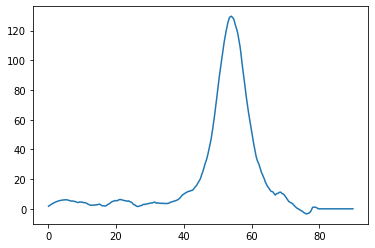

In [50]:
pk2=sp.signal.find_peaks(y,prominence=10,width=5,distance=1)[0]
plot(chi,y)
print(chi[pk2][0])
print(sp.signal.peak_widths(y,pk2)[0][0])

f =  0.12622955409981718  at scattering angle  28.280030261140336
   f =  1  for edge-on
   f =  0.7460048134630219  for random
 f' =  -2.440106317813918  normalized


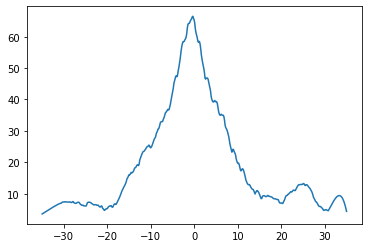

In [80]:
##### HERMAN ORIENTATION PARAMETER #####

import scipy as s
from scipy import integrate

target=peaks_tth[2]

num=[] # integrand in numerator
den=[] # integrand in denominator
I2m=y # takes the value at the [column] position from every array (azimuthal angle) in I22 arrays
chi_rad=[] # chi in radians

##### removing 0-valued pixels for integration
new_chi=chi
new_I2m=I2m

# for i in range(int(len(chi)/2)):
#     if (I2m[i] > 0):
#         new_chi.append(chi[i])
#         new_I2m.append(I2m[i])

        
##### populating numerator and denominator integrand arrays and chi-in-radians array
for i in range(0,len(new_chi)):
    chi_rad.append(new_chi[i]*math.pi/180)
for i in range(0,len(chi_rad)):
    num.append(new_I2m[i]*(math.cos(chi_rad[i]))**2*math.sin(chi_rad[i]))
    den.append(new_I2m[i]*math.sin(chi_rad[i]))

plt.plot(new_chi,new_I2m)

##### finding the baseline for no preferential orientation (random orientation)
anum= lambda x: math.cos(x)**2*math.sin(x)
aden= lambda x: math.sin(x)

##### trapezoidal integration
numint=s.integrate.trapz(num,chi_rad)
denint=s.integrate.trapz(den,chi_rad)

anumint=s.integrate.quad(anum,0,chi_rad[-1])
adenint=s.integrate.quad(aden,0,chi_rad[-1])

a = anumint[0]/adenint[0]
S_ran=0.5*(3*a-1)

cos2_avg=numint/denint

##### orientation parameter
f=0.5*(3*cos2_avg-1)
f_norm=(f-S_ran)/(1-S_ran)

print("f = ",f," at scattering angle ",target)
print("   f = ", 1, " for edge-on")
print("   f = ", S_ran, " for random")
print(" f' = ", f_norm, " normalized")